08:28:49 - cmdstanpy - INFO - Chain [1] start processing
08:28:49 - cmdstanpy - INFO - Chain [1] done processing
08:28:50 - cmdstanpy - INFO - Chain [1] start processing
08:28:50 - cmdstanpy - INFO - Chain [1] done processing
08:28:51 - cmdstanpy - INFO - Chain [1] start processing
08:28:51 - cmdstanpy - INFO - Chain [1] done processing



📋 Metriken LGBM (Bereitschaft):


,Monat,MAE_Baseline,RMSE_Baseline,Under_Baseline,Over_Baseline,MAE_90,RMSE_90,Under_90,Over_90
0,February,36.44,106.78,0.21,0.79,95.00,116.20,0.07,0.93
1,March,110.60,167.84,0.42,0.58,124.03,155.30,0.39,0.61
2,April,183.74,246.45,0.43,0.57,205.77,300.67,0.47,0.53
3,Durchschnitt,110.26,173.69,0.36,0.64,141.60,190.72,0.31,0.69


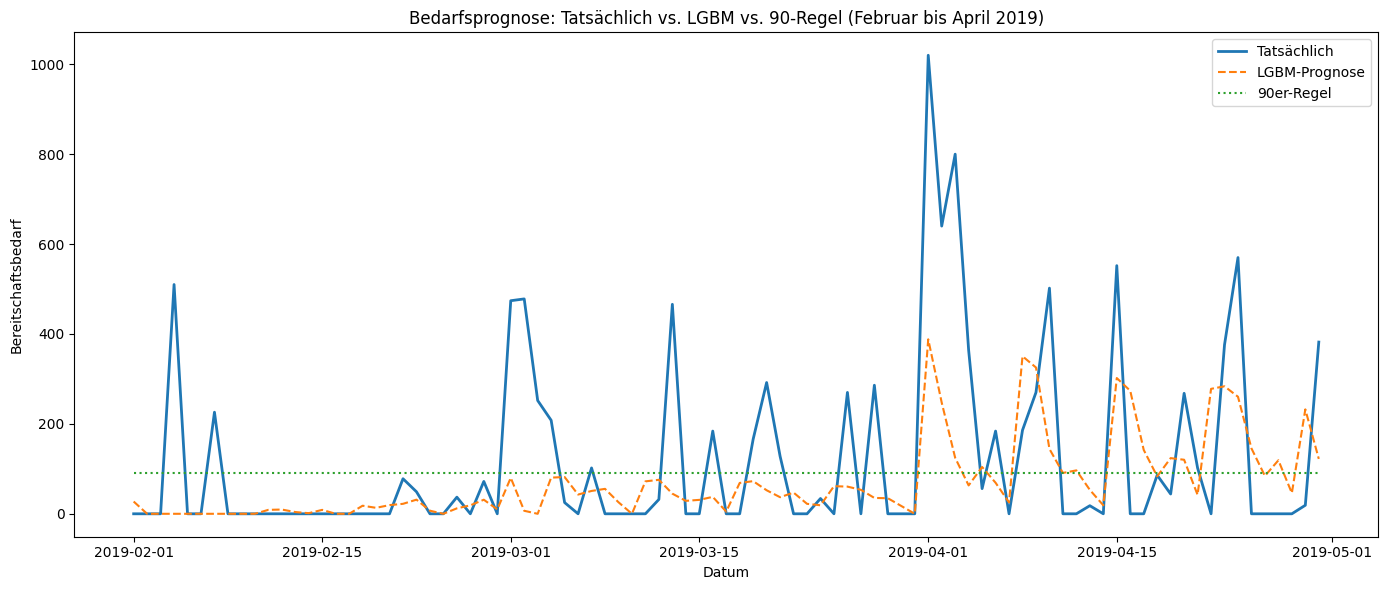

In [8]:
# 07_model_lgbm_final_eval.ipynb

import os
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from lightgbm import LGBMRegressor
import numpy as np

# --------------------------------------
# 1. Hilfsfunktion: Modellkonfiguration laden
# --------------------------------------
def load_best_prophet_model(target: str) -> dict:
    if target == "calls":
        model_path = os.path.abspath("../models/prophet/best_params.parquet")
    elif target == "target_bereitschaft":
        model_path = os.path.abspath("../models/lgbm/best_params.parquet")
    else:
        raise ValueError(f"Unbekanntes Ziel: {target}")

    best_models = pd.read_parquet(model_path)
    best_model = best_models.iloc[0]

    return {
        "features": list(best_model["features"]),
        "params": best_model["params"],
        "use_holidays": best_model["groups"].endswith("+H") if "groups" in best_model else False
    }

# --------------------------------------
# 2. Daten laden
# --------------------------------------
df_path = os.path.abspath("../data/processed/sickness_table.parquet")
df = pd.read_parquet(df_path)
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")
df["ds"] = df.index

holiday_path = os.path.abspath("../data/processed/holiday.parquet")
holidays_raw = pd.read_parquet(holiday_path)
holiday_df = pd.DataFrame({
    "holiday": holidays_raw["name"],
    "ds": holidays_raw["date"],
    "lower_window": -2,
    "upper_window": 2
})

# --------------------------------------
# 3. Phase 1 – calls vorhersagen
# --------------------------------------
calls_config = load_best_prophet_model("calls")
features_calls = calls_config["features"]
params_calls = calls_config["params"]
use_holidays_calls = calls_config["use_holidays"]

def predict_calls_for_month(df, vorhersagedatum):
    forecast_start = (vorhersagedatum + pd.offsets.MonthBegin(1)).replace(day=1)
    forecast_end = forecast_start + pd.offsets.MonthEnd(0)
    forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="D")

    df_calls = df.copy()
    df_calls = df_calls.rename(columns={"calls": "y"})

    df_train = df_calls.loc[:vorhersagedatum].copy()
    df_model = df_train[["ds", "y"] + features_calls].copy()

    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holiday_df if use_holidays_calls else None,
        **params_calls
    )
    for feat in features_calls:
        model.add_regressor(feat)
    model.fit(df_model)

    df_forecast_input = df_calls.loc[forecast_dates][["ds"] + features_calls].copy()
    forecast = model.predict(df_forecast_input)

    df_forecast = df_forecast_input.copy()
    df_forecast["calls_pred"] = forecast["yhat"].values

    return df_forecast[["ds", "calls_pred"]]

# --------------------------------------
# 4. Phase 2 – target_bereitschaft vorhersagen
# --------------------------------------
target_config = load_best_prophet_model("target_bereitschaft")
features_target = target_config["features"]
params_target = target_config["params"]

def predict_target_bereitschaft_with_calls(df, calls_forecast, vorhersagedatum):
    forecast_start = (vorhersagedatum + pd.offsets.MonthBegin(1)).replace(day=1)
    forecast_end = forecast_start + pd.offsets.MonthEnd(0)
    forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="D")

    df_hist = df.loc[:vorhersagedatum].copy()
    df_hist["calls_pred"] = df_hist["calls"]

    model = LGBMRegressor(
        objective='quantile', alpha=0.9,
        random_state=42, verbose=-1, **params_target
    )

    input_cols = ["target_bereitschaft", "calls_pred"] + features_target
    Xy_train = df_hist[input_cols].dropna()  # nur vollständige Zeilen behalten
    y_train = Xy_train.pop("target_bereitschaft")
    X_train = Xy_train

    model.fit(X_train, y_train)

    y_hist = df_hist["target_bereitschaft"].copy()
    preds = []

    for date in forecast_dates:
        row = pd.DataFrame(index=[date])

        for feat in features_target:
            if feat.startswith("lag_target_bereitschaft"):
                lag = int(feat.split("_")[-1])
                row[feat] = y_hist.get(date - pd.Timedelta(days=lag), np.nan)
            elif feat.startswith("roll_target_bereitschaft"):
                parts = feat.split("_")
                stat = parts[-2]
                win = int(parts[-1])
                ts = date - pd.Timedelta(days=1)
                series = y_hist.shift(1).rolling(window=win, min_periods=1)
                if stat == "mean":
                    row[feat] = series.mean().get(ts, np.nan)
                elif stat == "std":
                    row[feat] = series.std().get(ts, np.nan)
                elif stat == "min":
                    row[feat] = series.min().get(ts, np.nan)
                elif stat == "max":
                    row[feat] = series.max().get(ts, np.nan)

        row["calls_pred"] = calls_forecast.set_index("ds").at[date, "calls_pred"]
        for feat in features_target:
            if not feat.startswith("lag_") and not feat.startswith("roll_"):
                row[feat] = df.loc[date, feat]

        row = row[["calls_pred"] + features_target].bfill().ffill()
        pred = model.predict(row)[0]
        preds.append((date, pred))
        y_hist.loc[date] = pred

    df_forecast = pd.DataFrame(preds, columns=["ds", "target_pred"]).set_index("ds")
    df_eval = df.loc[forecast_dates][["target_bereitschaft"]].rename(columns={"target_bereitschaft": "target_true"})
    df_forecast = df_forecast.merge(df_eval, left_index=True, right_index=True, how="left")
    df_forecast["target_90_rule"] = 90
    df_forecast["abs_error"] = (df_forecast["target_pred"] - df_forecast["target_true"]).abs()
    return df_forecast

# --------------------------------------
# 5. Evaluation: Februar – April 2019
# --------------------------------------
monate = ["2019-01-15", "2019-02-15", "2019-03-15"]
alle_ergebnisse = []

for vdatum in monate:
    df_calls_pred = predict_calls_for_month(df, pd.Timestamp(vdatum))
    df_monat = predict_target_bereitschaft_with_calls(df, df_calls_pred, pd.Timestamp(vdatum))

    mae_b = mean_absolute_error(df_monat["target_true"], df_monat["target_pred"])
    rmse_b = sqrt(mean_squared_error(df_monat["target_true"], df_monat["target_pred"]))
    under_b = (df_monat["target_pred"] < df_monat["target_true"]).sum() / len(df_monat)
    over_b = (df_monat["target_pred"] > df_monat["target_true"]).sum() / len(df_monat)

    mae_90 = mean_absolute_error(df_monat["target_true"], df_monat["target_90_rule"])
    rmse_90 = sqrt(mean_squared_error(df_monat["target_true"], df_monat["target_90_rule"]))
    under_90 = (df_monat["target_90_rule"] < df_monat["target_true"]).sum() / len(df_monat)
    over_90 = (df_monat["target_90_rule"] > df_monat["target_true"]).sum() / len(df_monat)

    monat = (pd.Timestamp(vdatum) + pd.DateOffset(months=1)).strftime("%B")
    alle_ergebnisse.append({
        "Monat": monat,
        "MAE_Baseline": mae_b,
        "RMSE_Baseline": rmse_b,
        "Under_Baseline": under_b,
        "Over_Baseline": over_b,
        "MAE_90": mae_90,
        "RMSE_90": rmse_90,
        "Under_90": under_90,
        "Over_90": over_90,
        "df_monat": df_monat
    })

# --------------------------------------
# 6. Ergebnisvergleich als Tabelle
# --------------------------------------
df_metrics = pd.DataFrame(alle_ergebnisse).drop(columns=["df_monat"])
df_avg = df_metrics.drop(columns=["Monat"]).mean().to_frame().T
df_avg["Monat"] = "Durchschnitt"
df_final = pd.concat([df_metrics, df_avg], ignore_index=True)
print("\n📋 Metriken LGBM (Bereitschaft):")
display(df_final.round(2))

# --------------------------------------
# 7. Visualisierung & Speicherung
# --------------------------------------
alle_monate = pd.concat([eintrag["df_monat"] for eintrag in alle_ergebnisse])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(alle_monate.index, alle_monate["target_true"], label="Tatsächlich", linewidth=2)
ax.plot(alle_monate.index, alle_monate["target_pred"], label="LGBM-Prognose", linestyle='--')
ax.plot(alle_monate.index, alle_monate["target_90_rule"], label="90er-Regel", linestyle=':')
ax.set_title("Bedarfsprognose: Tatsächlich vs. LGBM vs. 90-Regel (Februar bis April 2019)")
ax.set_ylabel("Bereitschaftsbedarf")
ax.set_xlabel("Datum")
ax.legend()
fig.tight_layout()

# Grafik speichern
fig_dir = os.path.abspath("../reports/figures/lgbm")
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, "lgbm_forecast_feb_apr_2019.png")
fig.savefig(fig_path, dpi=300)

plt.show()

# Prognosedaten speichern
forecast_path = os.path.abspath("../data/predictions/lgbm_target.parquet")
os.makedirs(os.path.dirname(forecast_path), exist_ok=True)
alle_monate.to_parquet(forecast_path, index=True)
